In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
torch.set_printoptions(threshold=torch.inf)
import numpy as np
import random

import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

sys.path.append(os.path.dirname(os.getcwd())) #Add project dir to path
# from utils.loadutils import standardize_vidimu
# from utils.loadutils2 import standardize_vidimu
# from utils.loadutils3 import standardize_vidimu
# from utils.loadutils4 import standardize_vidimu

def set_random_seed(seed=42):
    """Set random seed for reproducibility."""
    random.seed(seed)            # Python random module
    np.random.seed(seed)         # NumPy
    torch.manual_seed(seed)      # PyTorch
    torch.cuda.manual_seed_all(seed)  # For multi-GPU systems

    # Ensure deterministic behavior in some backends (optional)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Call this at the beginning of your training script
set_random_seed(42)


In [3]:
gridsearch_path = "/Volumes/Data_Drive/vidimu_gridsearch_out/gridsearchKD_11_24"
activities = ["A01", "A02", "A03", "A04", "A05", "A06", "A07", "A08", "A09", "A10", "A11", "A12", "A13"]
secs=[0.5, 0.75, 1.5, 4.0]
depth=[1, 2, 7, 14]

In [4]:
import re
import pandas as pd

def parse_log_file(log_file_path, d, s):
    # Define regex patterns
    best_model_pattern = r"New best model saved as (.+)"
    metrics_pattern = r"Epoch \[\d+/\d+\], Loss: ([\d.]+), Train Accuracy: ([\d.]+), Test Accuracy: ([\d.]+), Precision: ([\d.]+), Recall: ([\d.]+), F1-Score: ([\d.]+)"
    loaded_model_accuracy_pattern = r"Loaded student model from .+_acc_([\d.]+)\.pth"

    # Initialize variables
    model_data = []
    initial_accuracy = None

    # Process the log file line by line
    with open(log_file_path, "r") as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            # Extract initial accuracy of the loaded student model
            if not initial_accuracy:
                loaded_model_match = re.search(loaded_model_accuracy_pattern, line)
                if loaded_model_match:
                    initial_accuracy = float(loaded_model_match.group(1))
            
            # Check for best model saved
            best_model_match = re.search(best_model_pattern, line)
            if best_model_match:
                metrics_line = lines[i - 2] if i >= 2 else None
                if metrics_line:
                    metrics_match = re.search(metrics_pattern, metrics_line)
                    if metrics_match:
                        trained_accuracy = float(metrics_match.group(3))
                        accuracy_diff = trained_accuracy - initial_accuracy
                        model_data.append({
                            "Depth": d,
                            "Time Window": s,
                            "Loss": float(metrics_match.group(1)),
                            "Train Accuracy": float(metrics_match.group(2)),
                            "Test Accuracy": trained_accuracy,
                            "Precision": float(metrics_match.group(4)),
                            "Recall": float(metrics_match.group(5)),
                            "F1-Score": float(metrics_match.group(6)),
                            "Accuracy Difference": accuracy_diff,
                        })
    
    # Return a DataFrame with the extracted data
    return pd.DataFrame(model_data)

# Initialize the results DataFrame
df_metrics = pd.DataFrame()

# Iterate over hyperparameter configurations
for d in depth:
    for s in secs:
        log_file_path = f'{gridsearch_path}/KD_log_{d}_{s}_42.txt'
        df_log = parse_log_file(log_file_path, d, s)
        if not df_log.empty:
            df_metrics = pd.concat([df_metrics, df_log], ignore_index=True)

# Find the best model for each configuration based on Test Accuracy
best_models = df_metrics.loc[df_metrics.groupby(["Depth", "Time Window"])["Test Accuracy"].idxmax()]
best_models.reset_index(drop=True, inplace=True)

# Display the best models
best_models

,Depth,Time Window,Loss,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score,Accuracy Difference
0,1,0.50,3.4632,0.9211,0.9014,0.9024,0.9014,0.9015,-0.0514
1,1,0.75,3.4592,0.9031,0.8708,0.8730,0.8708,0.8705,-0.0631
2,1,1.50,2.5000,0.8908,0.8519,0.8529,0.8519,0.8508,-0.0660
3,1,4.00,18.0609,0.8558,0.8326,0.8742,0.8326,0.8333,-0.1086
4,2,0.50,2.0867,0.9618,0.9350,0.9360,0.9350,0.9351,-0.0073
5,2,0.75,2.6734,0.9297,0.8786,0.8821,0.8786,0.8791,-0.0475
6,2,1.50,2.9910,0.9029,0.8680,0.8701,0.8680,0.8676,-0.0547
7,2,4.00,1.2434,0.9262,0.9140,0.9148,0.9140,0.9129,-0.0272
8,7,0.50,1.3859,0.9830,0.9465,0.9469,0.9465,0.9466,0.0042
9,7,0.75,1.1954,0.9784,0.9191,0.9219,0.9191,0.9195,-0.0031


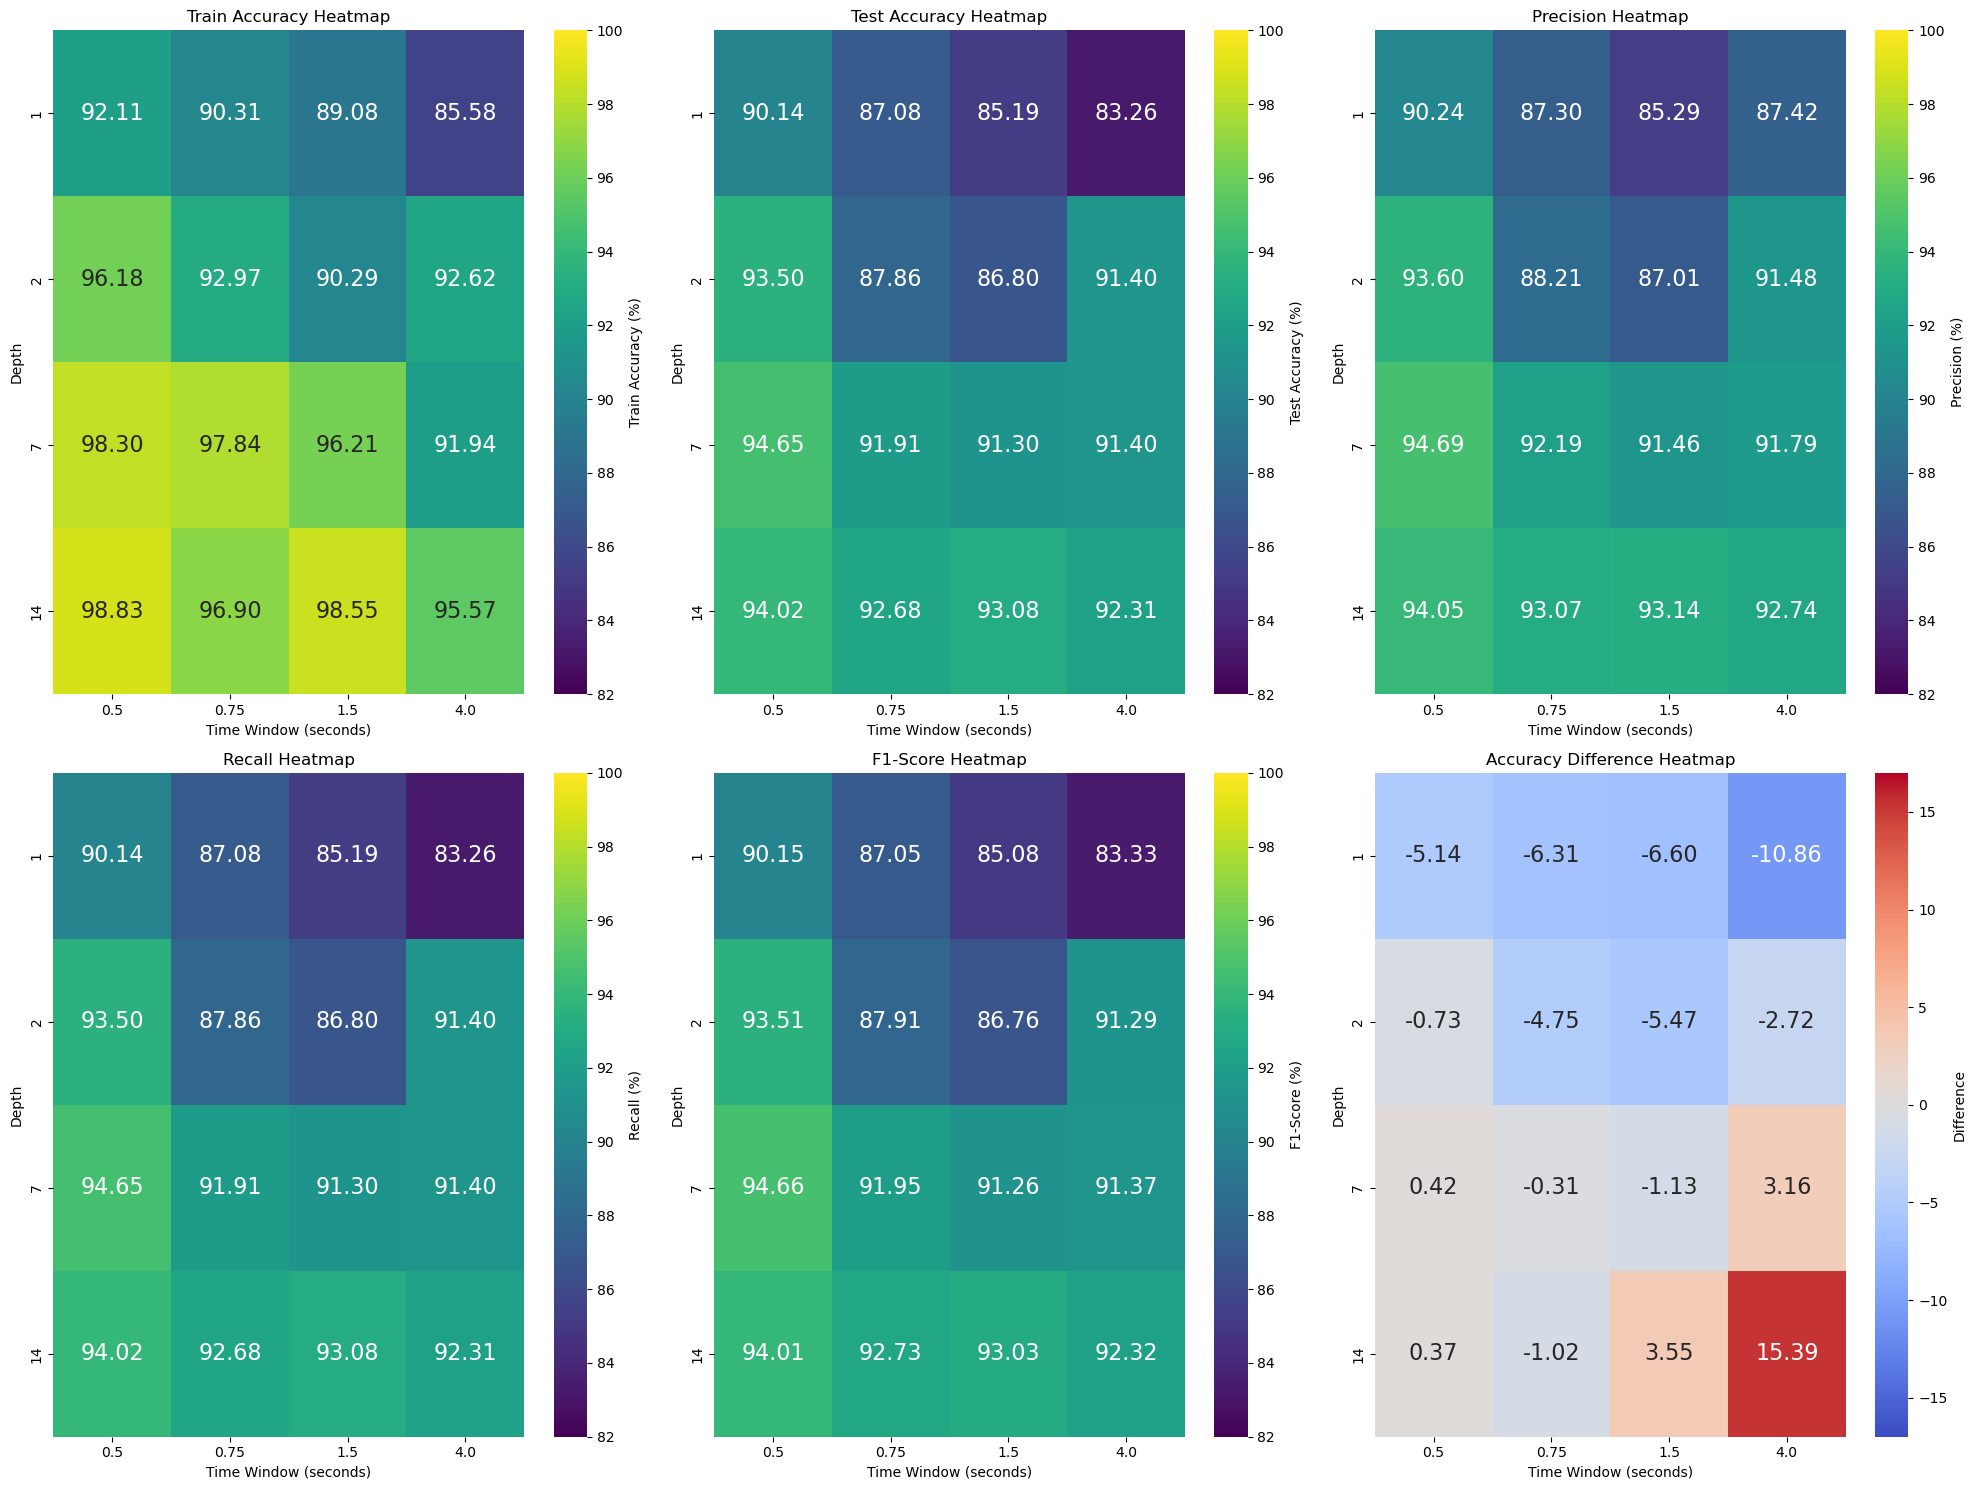

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics to plot
metrics = ["Train Accuracy", "Test Accuracy", "Precision", "Recall", "F1-Score", "Accuracy Difference"]

# Set up the figure with 2 rows and 3 columns
plt.figure(figsize=(20, 15))

# Iterate through each metric
for col_idx, metric in enumerate(metrics):
    # Pivot the data to create a matrix for heatmap
    heatmap_data = best_models.pivot(index="Depth", columns="Time Window", values=metric)
    
    # Define limits for the color bar and transformation
    vmin, vmax = (82, 100) if metric != "Accuracy Difference" else (-17, 17)
    # if metric in ["Train Accuracy", "Test Accuracy", "Precision", "Recall", "F1-Score"]:
    heatmap_data *= 100  # Convert to percentages
    fmt = ".2f"  # Two decimal places
    cmap = "viridis" if metric != "Accuracy Difference" else "coolwarm"
    
    # Create subplot
    plt.subplot(2, 3, col_idx + 1)
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=fmt,
        cmap=cmap,
        annot_kws={"size": 16}, 
        cbar_kws={'label': f"{metric} (%)" if metric != "Accuracy Difference" else "Difference"},
        vmin=vmin,
        vmax=vmax,
    )
    plt.title(f"{metric} Heatmap")
    plt.xlabel("Time Window (seconds)")
    plt.ylabel("Depth")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('evalKD.png')
plt.show()